In [1]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [3]:
batchSize = 10

In [4]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [5]:
def get_critic_scores(real_batch, batchSize, critic, generator):
    generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 512, 1, 1])
    generated = generator(randoBatch)
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [6]:
def get_generator_score(batchSize, critic, generator):
    generator.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 512, 1, 1])
    generated = generator(randoBatch)
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return torch.sum(gen_scores)

In [22]:
critic = Critic()
generator = Generator()

In [23]:
num_epochs = 10
critic_epochs = 2
gen_epochs = 2

In [24]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.01, momentum=0)
genOptim = optim.RMSprop(generator.parameters(), lr=0.01, momentum=0)

In [27]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic, generator)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) + 0.001 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic, generator)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
-850.8722686767578
-942.9894561767578
1690.3168334960938
Generator batch: 0
Generator batch: 1
-6686.728271484375
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
2335.8897438049316
3517.13570022583
19562.875959396362
Generator batch: 0
Generator batch: 1
1001.1977233886719
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
-53.49623107910156
-296.59776306152344
43.218204498291016
Generator batch: 0
Generator batch: 1
124.32286071777344
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
9.89276123046875
56.4971923828125
87.24850082397461
Generator batch: 0
Generator batch: 1
272.88731384277344
Entering epoch yay: 4
Critic batch: 0
Critic batch: 1
-77.85611724853516
-147.33363723754883
-29.262065887451172
Generator batch: 0
Generator batch: 1
-10.025289535522461
Entering epoch yay: 5
Critic batch: 0
Critic batch: 1
62.26783752441406
-442.4335079193115
-235.63470458984375
Generator batch: 0
Generator batch: 1
58.81368446350

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


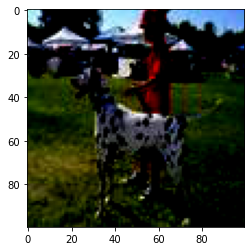

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[48.7613]], grad_fn=<AddmmBackward>)
tensor([[-64.8699]], grad_fn=<AddmmBackward>)


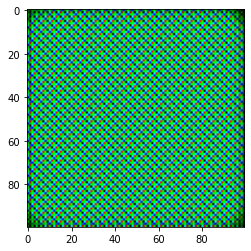

In [28]:
import matplotlib.pyplot as plt
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[0][0].unsqueeze(0)))
rando = torch.rand([1, 512, 1, 1])
print(critic(generator(rando)))

gen = generator(rando)
plt.imshow(gen[0].permute(1,2,0).detach().numpy())
plt.show()